<a href="https://colab.research.google.com/github/AthiramolCusat/Testing/blob/main/Copy_of_Copy_of_MASK_RCNN_TF_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation

In [ ]:
!git clone https://github.com/akTwelve/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 979, done.
remote: Total 979 (delta 0), reused 0 (delta 0), pack-reused 979
Receiving objects: 100% (979/979), 137.72 MiB | 14.98 MiB/s, done.
Resolving deltas: 100% (570/570), done.


In [ ]:
!pip install -r 'Mask_RCNN/requirements.txt'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.0/121.0 KB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 KB 10.8 MB/s eta 0:00:00


In [ ]:
!cd Mask_RCNN ; python setup.py install

/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/setuptools/dist.py:697: UserWarning: Usage of dash-separated 'requirements-file' will not be supported in future versions. Please use the underscore name 'requirements_file' instead
  warnings.warn(
running install
running bdist_egg
running egg_info
creating mask_rcnn.egg-info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'


In [ ]:
!pip show mask-rcnn

Name: mask-rcnn
Version: 2.1
Summary: Mask R-CNN for object detection and instance segmentation
Home-page: https://github.com/matterport/Mask_RCNN
Author: Matterport
Author-email: waleed.abdulla@gmail.com
License: MIT
Location: /usr/local/lib/python3.8/dist-packages/mask_rcnn-2.1-py3.8.egg
Requires: 
Required-by: 


#Working with the Dataset

In [ ]:
!git clone https://github.com/experiencor/kangaroo.git

Cloning into 'kangaroo'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 18.39 MiB | 8.63 MiB/s, done.
Resolving deltas: 100% (158/158), done.


Restart Runtime!!!

No. of training images: 131
No. of test images: 32
(3, 4) (388, 550, 3) (3,)


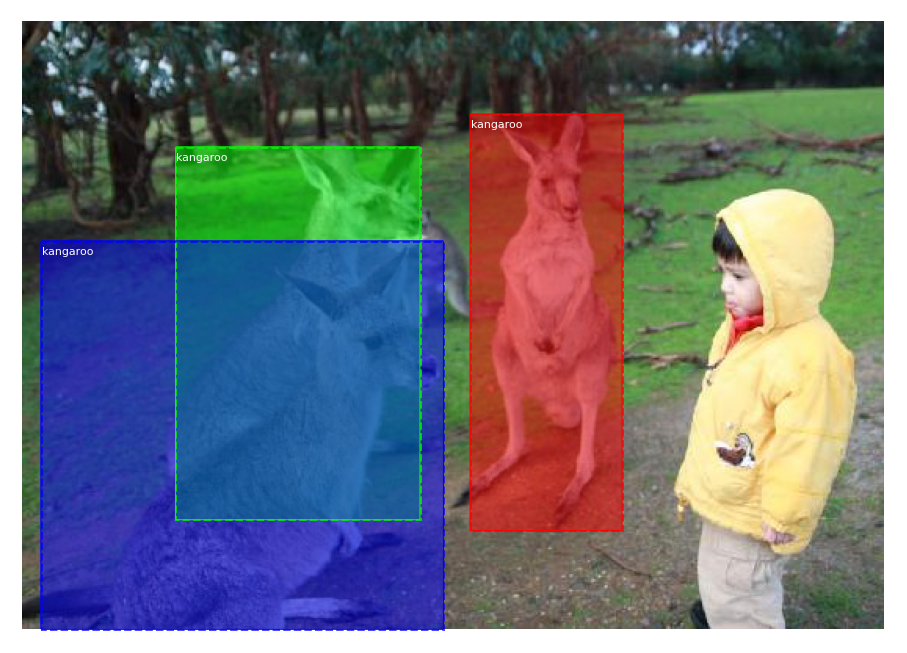

In [ ]:
from os import listdir
from xml.etree import ElementTree
from numpy import zeros
from numpy import asarray
from mrcnn.utils import Dataset
from matplotlib import pyplot
from mrcnn.visualize import display_instances
from mrcnn.utils import extract_bboxes

class KangarooDataset(Dataset):
  # load the dataset
  def load_dataset(self, dataset_dir, is_train=True):
    # define class
    self.add_class("dataset", 1, "kangaroo")
    # data location
    image_dir = dataset_dir + '/images/'
    annotation_dir = dataset_dir + '/annots/'
    # find images
    for filename in listdir(image_dir):
      # get image id
      image_id = filename[:-4]
      # image 00090.jpg had some problem so we will skip it
      if image_id in ['00090']:
        continue
      # for training set get images upto 150
      if is_train and int(image_id) >= 150:
        continue
      # for test set get images after 151 till the end
      if not is_train and int(image_id) < 150:
        continue
      img_path = image_dir + filename
      ann_path = annotation_dir + image_id + '.xml'
      # add to dataset
      self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)

  #Extract bounding boxes from XML file
  def extract_bnd_boxes(self,filename):
    # load and parse the XML file
    xml_file= ElementTree.parse(filename)
    # get the root directory
    root = xml_file.getroot()
    # extract the bounding boxes
    bnd_boxes = list()
    for box in root.findall('.//bndbox'):
      xmin = int(box.find('xmin').text)
      ymin = int(box.find('ymin').text)
      xmax = int(box.find('xmax').text)
      ymax = int(box.find('ymax').text)
      box = [xmin, ymin, xmax, ymax]
      bnd_boxes.append(box)
      # extract the image dimensions
      width = int(root.find('.//size/width').text)
      height = int(root.find('.//size/height').text)
    return bnd_boxes, width, height

  # load masks for the given image_id
  def load_mask(self, image_id):
    # get the image_info for the given image_id
    img_info = self.image_info[image_id]
    # get path of the annotation file of the given image_id
    path = img_info['annotation']
    # get the bounding boxes and image dims
    bnd_boxes, w, h = self.extract_bnd_boxes(path)
    # create an array for masks
    masks = zeros([h, w, len(bnd_boxes)], dtype='uint8')
    # create masks
    class_ids = list()
    for i in range(len(bnd_boxes)):
      box = bnd_boxes[i]
      ymin, ymax = box[1], box[3]
      xmin, xmax = box[0], box[2]
      masks[ymin:ymax, xmin:xmax, i] = 1
      class_ids.append(self.class_names.index('kangaroo'))
    return masks, asarray(class_ids, dtype='int32')

  # load the image path
  def image_reference(self, image_id):
    # get the image_info for the given image_id
    img_info = self.image_info[image_id]
    # return the value of the key 'path' -> image path
    return img_info['path']


# training dataset
train_dataset = KangarooDataset()
train_dataset.load_dataset('kangaroo', is_train=True)
train_dataset.prepare()
print('No. of training images: %d' % len(train_dataset.image_ids))
# test dataset
test_dataset = KangarooDataset()
test_dataset.load_dataset('kangaroo', is_train=False)
test_dataset.prepare()
print('No. of test images: %d' % len(test_dataset.image_ids))


# image id
image_id = 10
# load image
image = train_dataset.load_image(image_id)
# load masks and the class ids for the give image_id
mask, class_ids = train_dataset.load_mask(image_id)
# extract bounding boxes from the masks
box = extract_bboxes(mask)
print(box.shape,mask.shape,class_ids.shape)
# display the image with masks and bounding boxes
display_instances(image, box, mask, class_ids, train_dataset.class_names)

#Train the Model using Kangaroo Dataset

In [ ]:
import os
ROOT_DIR = os.getcwd()
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
# Local path to trained weights file
from mrcnn import utils
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

... done downloading pretrained model!


In [ ]:
from mrcnn.config import Config
from mrcnn.model import MaskRCNN

# define a configuration for the model
class KangarooConfig(Config):
  # Give the configuration a recognizable name
  NAME = "kangaroo_cfg"
  # Number of classes (background + kangaroo)
  NUM_CLASSES = 1 + 1
  # Number of training steps per epoch
  STEPS_PER_EPOCH = 131

# define a config object
config = KangarooConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

In [ ]:
# define the model
model = MaskRCNN(mode='training', model_dir=MODEL_DIR, config=config)

# load pre-trained weights of mscoco and exclude the output layers
model.load_weights('mask_rcnn_coco.h5', by_name=True, exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# train the model(only the output layers)
model.train(train_dataset, test_dataset, learning_rate=config.LEARNING_RATE, epochs=1, layers='heads')

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089



Starting at epoch 0. LR=0.001

Checkpoint Path: /content/logs/kangaroo_cfg20230223T1027/mask_rcnn_kangaroo_cfg_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc          (TimeDistributed)
mrcnn_mask_deconv     

#Evaluate the Model

In [ ]:
class PredictionConfig(Config):
  # name of the configuration
  NAME = "kangaroo_cfg"
  # number of classes (background + kangaroo)
  NUM_CLASSES = 1 + 1
  # GPU configuration
  GPU_COUNT = 1
  IMAGES_PER_GPU = 1

In [ ]:
# create PredictionConfig object to make prediction
cfg = PredictionConfig()
# define the model with mode set to inference
model = MaskRCNN(mode='inference', model_dir=MODEL_DIR, config=cfg)

# get the model path
model_path = model.find_last()

# load trained weights
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
from numpy import expand_dims
from numpy import mean
from mrcnn.utils import compute_ap
from mrcnn.model import load_image_gt
from mrcnn.model import mold_image

# calculate mAP for the model
def evaluate_model(dataset, model, cfg):
  APs = list()
  for image_id in dataset.image_ids:
    # load image, bounding boxes and masks for the given image id
    image, image_meta, gt_class_id, gt_bbox, gt_mask = load_image_gt(dataset, cfg, image_id, use_mini_mask=False)
    # convert pixel values of the image
    molded_image = mold_image(image, cfg)
    # expand the shape of the image
    new_img = expand_dims(molded_image, 0)
    # make prediction
    predict = model.detect(new_img, verbose=0)
    # extract results for first axis
    pos0 = predict[0]
    # compute AP
    AP, _, _, _ = compute_ap(gt_bbox, gt_class_id, gt_mask, pos0["rois"], pos0["class_ids"], pos0["scores"], pos0['masks'])
    # store all the AP in the list
    APs.append(AP)
  # compute the mean AP across the dataset
  mAP = mean(APs)
  return mAP

# evaluate on training dataset
training_mAP = evaluate_model(train_dataset, model, cfg)
print("Train mAP: %.3f" % training_mAP)
# evaluate model on test dataset
testing_mAP = evaluate_model(test_dataset, model, cfg)
print("Test mAP: %.3f" % testing_mAP)

#Detect Kangaroos in Any Picture

In [ ]:
import cv2
from matplotlib.patches import Rectangle

img1 = cv2.imread(r'/content/Kangaroo1.jpg')
img2 = cv2.imread(r'/content/Kangaroo2.jpg')
images = [img1,img2]

pyplot.figure(figsize = (20,20))
for i in range(len(images)):
  img = images[i]
  molded_image = mold_image(img,cfg)
  new_img = expand_dims(molded_image,0)
  predict = model.detect(new_img, verbose = 0)

  pyplot.subplot(1,2,i+1)
  pyplot.imshow(img)
  pyplot.title('Predicted')
  ax = pyplot.gca()

  for box in predict[0]['rois']:
      y1,x1,y2,x2 = box
      width, height = x2 - x1, y2 - y1
      rectangle = Rectangle((x1, y1), width, height, fill=False, color='red')
      ax.add_patch(rectangle)